In [29]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from statistic import *
from heart import heart
from valve_p import ValveinP
from three_windkessel import PressureSystem
from testclass import *
sens = sensitivity()
T=60/75
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, # tau1,2 (s)
         m1 = 1.32, m2 = 27.4, # m1,2
         Emax = 3,Emin = 0.08, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)

la=heart(tau1 = 0.110*T, tau2 = 0.180*T, #tau1,2
         m1 = 1.32,m2 = 13.1, # m1,2
         Emax = 0.17, Emin = 0.08, #Emax,min(mmHg/mL)
         V0 = 3,T = T) # V0 (mL), T (s)

av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.12,Kvc = 0.15, # Kvo,Kvc
            p_oc = 0) #poc

mv=ValveinP(density = 1.06,eff_length = 1.25,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.3,Kvc = 0.4, # Kvo,Kvc
            p_oc = 0) #poc

cap_s=PressureSystem(0.0008, 90, 1200)#C,Za,R

rv=heart(0.269*T,0.452*T, # tau1, 2
         1.32,27.4, # m1,2
         0.6,0.04, #Emax, min
         10,T) # Ks, V0 ,T

ra=heart(0.110*T,0.180*T, # tau1, 2
         1.32,13.1, # m1,2
         0.15,0.04, # Emax,min
         3, T) # Ks, V0, T

tv=ValveinP(1.06,2,6, # density, eff_length, Aann(cm2)
            0.3,0.4, # Kvo,Kvc
            0) #poc (mmHg)

pv=ValveinP(1.06,1.9,2.8, # density, eff_length, Aann(cm2)
            0.2,0.2, # Kvo,Kvc
            0) #poc
t_end=50
t = [0,t_end]
t_span=np.arange(0,t_end,0.01)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,0.85*T)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,0.85*T)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy
rvef_zeta = []
lvef_zeta = []
sv_lv_zeta = []
sv_rv_zeta = []
p_lv_zeta_list = []
p_rv_zeta_list = []
p_pa_zeta_list = []
p_ao_zeta_list = []
v_lv_zeta_statistic = []
v_rv_zeta_statistic = []
for Za in range(20,100,10):
    cap_p=PressureSystem(0.0017, Za, 100)#C,Za,R
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]
    p_pa = []
    p_rv = []
    p_ao = []
    p_lv = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_ao.append(cap_p.pi(q_av[j],pa[j]))
        p_rv.append(rv.p(v_rv[j],i))
        p_lv.append(lv.p(v_lv[j],i))
    max_rv = max(sol.y[7][4120:4200])
    min_rv = min(sol.y[7][4120:4200])
    max_lv = max(sol.y[0][4120:4200])
    min_lv = min(sol.y[0][4120:4200])
    sv_rv_zeta.append(max_rv-min_rv)
    sv_lv_zeta.append(max_lv-min_lv)
    rvef_zeta.append(sv_rv_zeta[-1]/max_rv)
    lvef_zeta.append(sv_lv_zeta[-1]/max_lv)
    p_lv_zeta = list(map(lambda x: x / 1333, p_lv))
    p_lv_zeta_list.append(p_lv_zeta)
    p_rv_zeta = list(map(lambda x: x / 1333, p_rv))
    p_rv_zeta_list.append(p_rv_zeta)
    p_pa_zeta = list(map(lambda x: x / 1333, p_pa))
    p_pa_zeta_list.append(p_pa_zeta)
    p_ao_zeta = list(map(lambda x: x / 1333, p_ao))
    p_ao_zeta_list.append(p_ao_zeta)
    v_lv_zeta_statistic.append(v_lv)
    v_rv_zeta_statistic.append(v_rv)

In [30]:
za = np.array(range(20,100,10))
p_ao_zeta_list = np.array(p_ao_zeta_list)
p_pa_zeta_list = np.array(p_pa_zeta_list)
v_lv_zeta_statistic = np.array(v_lv_zeta_statistic)
v_rv_zeta_statistic = np.array(v_rv_zeta_statistic)
p_lv_zeta_list = np.array(p_lv_zeta_list)
p_rv_zeta_list = np.array(p_rv_zeta_list)
lvef_zeta = np.array(lvef_zeta)
rvef_zeta = np.array(rvef_zeta)

In [31]:
for i in range(len(za)):
    sens_p_ao_zeta_list = sens.sens_g(x = za, y = p_ao_zeta_list[:,4120:4200])
    sens_p_pa_zeta_list = sens.sens_g(x=za, y = p_pa_zeta_list[:,4120:4200])
    sens_v_lv_statistic = sens.sens_g(x=za, y= v_lv_zeta_statistic[:,4120:4200])
    sens_v_rv_statistic = sens.sens_g(x=za, y= v_rv_zeta_statistic[:,4120:4200])
    sens_p_lv_zeta_list = sens.sens_g(x=za, y = p_lv_zeta_list[:,4120:4200])
    sens_p_rv_zeta_list = sens.sens_g(x=za, y = p_rv_zeta_list[:,4120:4200])
    sens_rvef_zeta = sens.sens_g(x=za, y = rvef_zeta)
    sens_lvef_zeta = sens.sens_g(x=za, y = lvef_zeta)
    sens_sv_rv_za = sens.sens_g(x=za, y = sv_rv_zeta)
    sens_sv_lv_za = sens.sens_g(x=za, y = sv_lv_zeta)

In [32]:
print('p_ao:',sens_p_ao_zeta_list)
print('p_pa:',sens_p_pa_zeta_list)
print('v_lv:',sens_v_lv_statistic)
print('v_rv:',sens_v_rv_statistic)
print('p_rv:',sens_p_rv_zeta_list)
print('p_lv:',sens_p_lv_zeta_list)
print('rvef:',sens_rvef_zeta)
print('lvef:',sens_lvef_zeta)
print('svlv:',sens_sv_lv_za)
print('svrv:',sens_sv_rv_za)

p_ao: 24.33107274992113
p_pa: 85.87515130018406
v_lv: -0.051507954181044015
v_rv: 0.26426809876145196
p_rv: 0.30529055276830397
p_lv: -0.05854378134929477
rvef: -0.015159924470323086
lvef: -0.030181874582128863
svlv: -0.0867324615971765
svrv: 0.10513293437499002


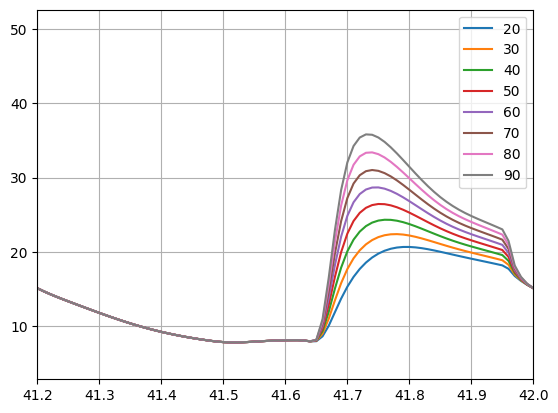

In [33]:
labels = [str(20+i*10) for i in range(len(p_pa_zeta_list))]
for i in range(len(p_pa_zeta_list)):
    plt.plot(sol.t, p_pa_zeta_list[i],label=labels[i])
plt.xlim(41.2,42)
plt.legend()
plt.grid()
plt.show()

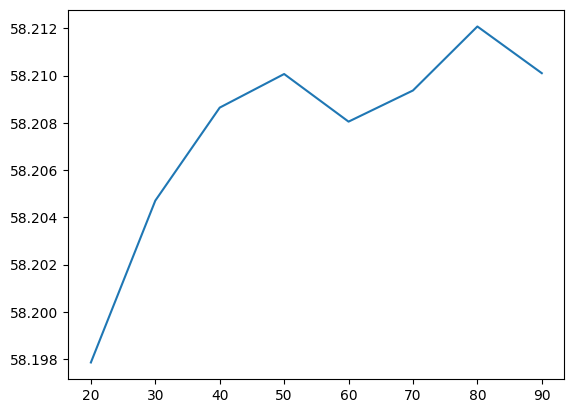

In [34]:
labels = [str(20+i*10) for i in range(len(p_pa_zeta_list))]
za=[float(20+i*10) for i in range(len(p_pa_zeta_list))]
plt.plot(za, sv_rv_zeta)
plt.show()

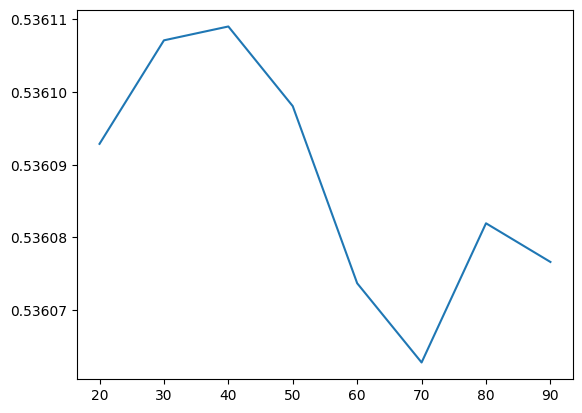

In [35]:
labels = [str(20+i*10) for i in range(len(p_pa_zeta_list))]
za=[float(20+i*10) for i in range(len(p_pa_zeta_list))]
plt.plot(za, rvef_zeta)
plt.show()

In [36]:
rvef_r = []
lvef_r = []
sv_lv_r = []
sv_rv_r = []
p_lv_r_list = []
p_rv_r_list = []
p_pa_r_list = []
p_ao_r_list = []
v_lv_r_statistic = []
v_la_r_statistic = []
v_rv_r_statistic = []
v_ra_r_statistic = []
for R in range(100,1000,100):
    cap_p=PressureSystem(0.0017, 25, R)#C,Za,R
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]
    p_pa = []
    p_rv = []
    p_ao = []
    p_lv = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_rv.append(rv.p(v_rv[j],i))
    max_rv = max(sol.y[7][4120:4200])
    min_rv = min(sol.y[7][4120:4200])
    max_lv = max(sol.y[0][4120:4200])
    min_lv = min(sol.y[0][4120:4200])
    sv_rv_r.append(max_rv-min_rv)
    sv_lv_r.append(max_lv-min_lv)
    rvef_r.append(sv_rv_zeta[-1]/max_rv)
    lvef_r.append(sv_lv_zeta[-1]/max_lv)
    p_lv_r = list(map(lambda x: x / 1333, p_lv))
    p_lv_r_list.append(p_lv_zeta)
    p_rv_r = list(map(lambda x: x / 1333, p_rv))
    p_rv_r_list.append(p_rv_zeta)
    p_pa_r = list(map(lambda x: x / 1333, p_pa))
    p_pa_r_list.append(p_pa_zeta)
    p_ao_r = list(map(lambda x: x / 1333, p_ao))
    p_ao_r_list.append(p_ao_zeta)
    v_lv_r_statistic.append(v_lv)
    v_rv_r_statistic.append(v_rv)

In [37]:
r = np.array(range(20,100,10))
p_ao_r_list = np.array(p_ao_r_list)
p_pa_r_list = np.array(p_pa_r_list)
v_lv_r_statistic = np.array(v_lv_r_statistic)
v_rv_r_statistic = np.array(v_rv_r_statistic)
p_lv_r_list = np.array(p_lv_r_list)
p_rv_r_list = np.array(p_rv_r_list)
lvef_r = np.array(lvef_r)
rvef_r = np.array(rvef_r)

In [38]:
for i in range(len(r)):
    sens_p_ao_r_list = sens.sens_g(x = r, y = p_ao_r_list[:,4120:4200])
    sens_p_pa_r_list = sens.sens_g(x=r, y = p_pa_r_list[:,4120:4200])
    sens_v_lv_r_statistic = sens.sens_g(x=r, y= v_lv_r_statistic[:,4120:4200])
    sens_v_rv_r_statistic = sens.sens_g(x=r, y= v_rv_r_statistic[:,4120:4200])
    sens_p_lv_r_list = sens.sens_g(x=r, y = p_lv_r_list[:,4120:4200])
    sens_p_rv_r_list = sens.sens_g(x=r, y = p_rv_r_list[:,4120:4200])
    sens_rvef_r = sens.sens_g(x=r, y = rvef_r)
    sens_lvef_r = sens.sens_g(x=r, y = lvef_r)
    sens_sv_rv_r = sens.sens_g(x=r, y = sv_rv_r)
    sens_sv_lv_r = sens.sens_g(x=r, y = sv_lv_r)

In [39]:
print('p_ao:',sens_p_ao_r_list)
print('p_pa:',sens_p_pa_r_list)
print('v_lv:',sens_v_lv_r_statistic)
print('v_rv:',sens_v_rv_r_statistic)
print('p_rv:',sens_p_rv_r_list)
print('p_lv:',sens_p_lv_r_list)
print('rvef:',sens_rvef_r)
print('lvef:',sens_lvef_r)
print('svlv:',sens_sv_lv_r)
print('svrv:',sens_sv_rv_r)

p_ao: 0.0
p_pa: 0.0
v_lv: -217.84755120567522
v_rv: 232.40928098150192
p_rv: 0.0
p_lv: 0.0
rvef: -112.17406553932497
lvef: 238.10362247322223
svlv: -257.920480176772
svrv: -261.67086055496554


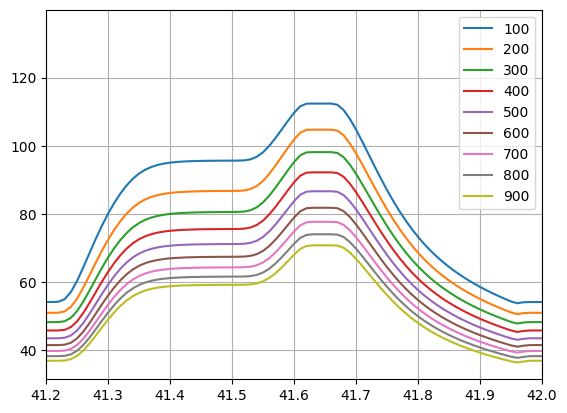

In [59]:
labels = [str(100+i*100) for i in range(len(p_pa_r_list))]
for i in range(len(p_pa_r_list)):
    plt.plot(sol.t, v_lv_r_statistic[i],label=labels[i])
plt.xlim(41.2,42)
plt.legend()
plt.grid()
plt.show()

In [ ]:
labels = [str(100+i*100) for i in range(len(p_pa_r_list))]
for i in range(len(p_pa_r_list)):
    plt.plot(sol.t, p_pa_r_list[i],label=labels[i])
plt.xlim(41.2,42)
plt.legend()
plt.grid()
plt.show()

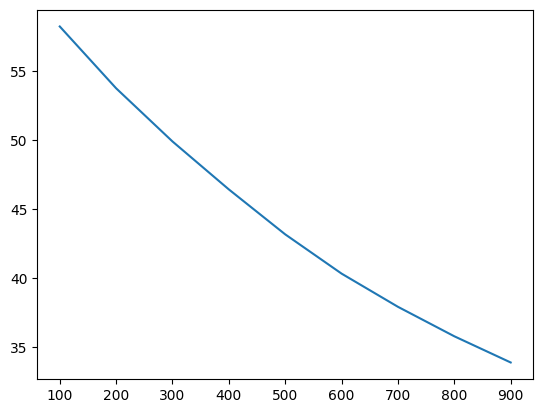

In [41]:
labels = [str(100+i*100) for i in range(len(p_pa_r_list))]
r=[float(100+i*100) for i in range(len(p_pa_r_list))]
plt.plot(r, sv_rv_r)
plt.show()

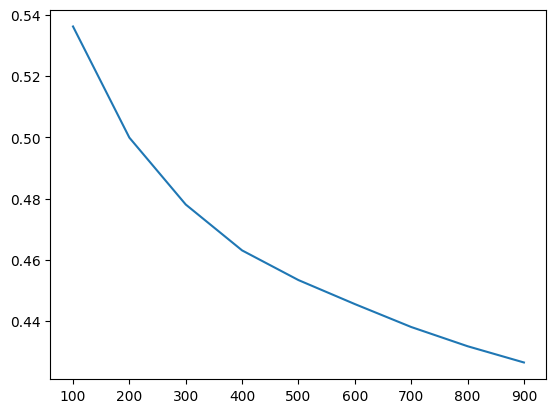

In [42]:
labels = [str(100+i*100) for i in range(len(p_pa_r_list))]
za=[float(100+i*100) for i in range(len(p_pa_r_list))]
plt.plot(r, rvef_r)
plt.show()

In [43]:
rvef_c = []
lvef_c = []
sv_lv_c = []
sv_rv_c = []
p_lv_c_list = []
p_rv_c_list = []
p_pa_c_list = []
p_ao_c_list = []
v_lv_c_statistic = []
v_la_c_statistic = []
v_rv_c_statistic = []
v_ra_c_statistic = []
for C in np.arange(0.0017,0.01,0.001):
    cap_p=PressureSystem(C, 25, 100)#C,Za,R
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]
    p_pa = []
    p_rv = []
    p_ao = []
    p_lv = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_rv.append(rv.p(v_rv[j],i))
    max_rv = max(sol.y[7][4120:4200])
    min_rv = min(sol.y[7][4120:4200])
    max_lv = max(sol.y[0][4120:4200])
    min_lv = min(sol.y[0][4120:4200])
    sv_rv_c.append(max_rv-min_rv)
    sv_lv_c.append(max_lv-min_lv)
    rvef_c.append(sv_rv_zeta[-1]/max_rv)
    lvef_c.append(sv_lv_zeta[-1]/max_lv)
    p_lv_c = list(map(lambda x: x / 1333, p_lv))
    p_lv_c_list.append(p_lv_zeta)
    p_rv_c = list(map(lambda x: x / 1333, p_rv))
    p_rv_c_list.append(p_rv_zeta)
    p_pa_c = list(map(lambda x: x / 1333, p_pa))
    p_pa_c_list.append(p_pa_zeta)
    p_ao_c = list(map(lambda x: x / 1333, p_ao))
    p_ao_c_list.append(p_ao_zeta)
    v_lv_c_statistic.append(v_lv)
    v_rv_c_statistic.append(v_rv)

In [44]:
c = np.array(np.arange(0.0017,0.01,0.001))
p_ao_c_list = np.array(p_ao_c_list)
p_pa_c_list = np.array(p_pa_c_list)
v_lv_c_statistic = np.array(v_lv_c_statistic)
v_rv_c_statistic = np.array(v_rv_c_statistic)
p_lv_c_list = np.array(p_lv_c_list)
p_rv_c_list = np.array(p_rv_c_list)
lvef_c = np.array(lvef_c)
rvef_c = np.array(rvef_c)

In [45]:
for i in range(len(c)):
    sens_p_ao_c_list = sens.sens_g(x = c, y = p_ao_c_list[:,4120:4200])
    sens_p_pa_c_list = sens.sens_g(x=c, y = p_pa_c_list[:,4120:4200])
    sens_v_lv_c_statistic = sens.sens_g(x=c, y= v_lv_c_statistic[:,4120:4200])
    sens_v_rv_c_statistic = sens.sens_g(x=c, y= v_rv_c_statistic[:,4120:4200])
    sens_p_lv_c_list = sens.sens_g(x=c, y = p_lv_c_list[:,4120:4200])
    sens_p_rv_c_list = sens.sens_g(x=c, y = p_rv_c_list[:,4120:4200])
    sens_rvef_c = sens.sens_g(x=c, y = rvef_c)
    sens_lvef_c = sens.sens_g(x=c, y = lvef_c)
    sens_sv_rv_c = sens.sens_g(x=c, y = sv_rv_c)
    sens_sv_lv_c = sens.sens_g(x=c, y = sv_lv_c)

In [46]:
print('p_ao:',sens_p_ao_c_list)
print('p_pa:',sens_p_pa_c_list)
print('v_lv:',sens_v_lv_c_statistic)
print('v_rv:',sens_v_rv_c_statistic)
print('p_rv:',sens_p_rv_c_list)
print('p_lv:',sens_p_lv_c_list)
print('rvef:',sens_rvef_c)
print('lvef:',sens_lvef_c)
print('svlv:',sens_sv_lv_c)
print('svrv:',sens_sv_rv_c)

p_ao: 0.0
p_pa: 0.0
v_lv: -63.5348469089008
v_rv: -119.87989988865488
p_rv: 0.0
p_lv: 0.0
rvef: 108.56450527170837
lvef: 55.45161717215274
svlv: -59.28499026030093
svrv: -59.77239806236676


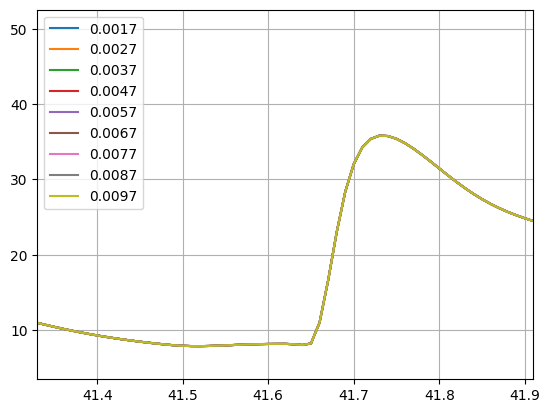

In [47]:
labels = [str(0.0017+i*0.001) for i in range(len(p_pa_c_list))]
for i in range(len(p_pa_c_list)):
    plt.plot(sol.t, p_pa_c_list[i],label=labels[i])
plt.xlim(41.33,41.91)
plt.legend()
plt.grid()
plt.show()

In [48]:
p_pa_c_list[0]
p_pa_c_list[1]

array([ 5.67516879,  5.80650078, 10.08208641, ..., 18.19302888,
       16.67205151, 15.73928424])

In [49]:
rvef_surgery = []
lvef_surgery = []
sv_rv_surgery = []
sv_lv_surgery = []
p_pa_surgery = []
p_rv_surgery = []
input_para = []
v_rv_surgery = []
v_ra_surgery = []
p_lv_surgery = []
v_lv_surgery = []
v_la_surgery = []
p_ao_surgery = []
input_para.append([12.5, 142.5,0.00875])#healthy, Za, R, C
input_para.append([10, 71.25, 0.004875])#pneumonectomy

In [50]:
for i in range(len(input_para)):
    cap_p=PressureSystem(input_para[i][2], input_para[i][0],input_para[i][1])#C,Za,R
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]
    p_pa = []
    p_ao = []
    p_rv = []
    p_lv = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_ao.append(cap_s.pi(q_av[j],pa[j]))
        p_rv.append(rv.p(v_rv[j],i))
        p_lv.append(lv.p(v_lv[j],i))
    max_rv = max(sol.y[7][4120:4300])
    min_rv = min(sol.y[7][4120:4300])
    v_ra_surgery.append(v_ra)
    v_rv_surgery.append(v_rv)
    sv_rv_surgery.append(max_rv-min_rv)
    sv_lv_surgery.append(max_lv-min_lv)
    rvef_surgery.append(sv_rv_surgery[-1]/max_rv)
    lvef_surgery.append(sv_lv_surgery[-1]/max_lv)
    p_pa_count = list(map(lambda x: x / 1333, p_pa))
    p_pa_surgery.append(p_pa_count)
    p_ao_count = list(map(lambda x: x / 1333, p_ao))
    p_ao_surgery.append(p_ao_count)
    p_rv_count = list(map(lambda x: x / 1333, p_rv))
    p_rv_surgery.append(p_rv_count)
    p_lv_count = list(map(lambda x: x / 1333, p_lv))
    p_lv_surgery.append(p_lv_count)
    v_la_surgery.append(v_la)
    v_lv_surgery.append(v_lv)

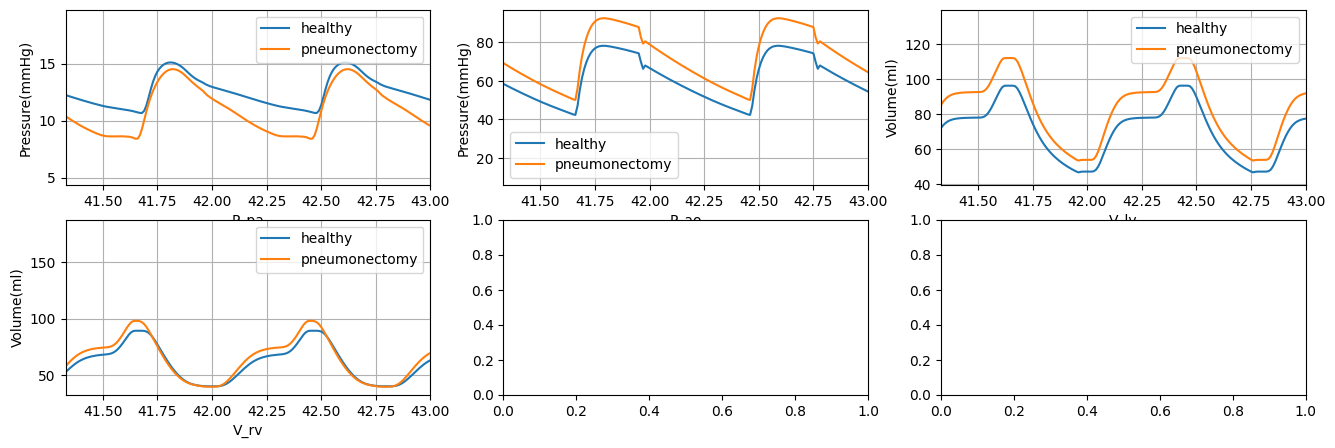

In [64]:
fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(16,5))
labels = ['healthy','pneumonectomy']
for i in range(len(p_pa_surgery)):
    ax1.plot(sol.t, p_pa_surgery[i],label =labels[i])
ax1.set_xlim(41.33,43)
ax1.set_ylabel('Pressure(mmHg)')
ax1.set_xlabel('P_pa')
ax1.legend()
ax1.grid()

for i in range(len(p_ao_surgery)):
    ax2.plot(sol.t, p_ao_surgery[i],label =labels[i])
ax2.set_xlim(41.33,43)
ax2.set_ylabel('Pressure(mmHg)')
ax2.set_xlabel('P_ao')
ax2.legend()
ax2.grid()

for i in range(len(p_pa_surgery)):
    ax3.plot(sol.t, v_lv_surgery[i],label =labels[i])
ax3.set_xlim(41.33,43)
ax3.set_ylabel('Volume(ml)')
ax3.set_xlabel('V_lv')
ax3.legend()
ax3.grid()
for i in range(len(p_pa_surgery)):
    ax4.plot(sol.t, v_rv_surgery[i],label =labels[i])
ax4.set_xlim(41.33,43)
ax4.set_ylabel('Volume(ml)')
ax4.set_xlabel('V_rv')
ax4.legend()
ax4.grid()
plt.show()

In [61]:
print(sv_rv_surgery)
print(rvef_surgery)
print(lvef_surgery)

[array([135.        , 134.12557832, 132.93594633, ...,  47.08985222,
        47.20952454,  47.20980962]), array([135.        , 134.1255112 , 132.93579126, ...,  53.82462685,
        53.89707049,  53.89714219])]
[49.013180524285715, 58.075854990706276]
[0.548961060172608, 0.592465125133144]
[0.5168691766779525, 0.5168691766779525]


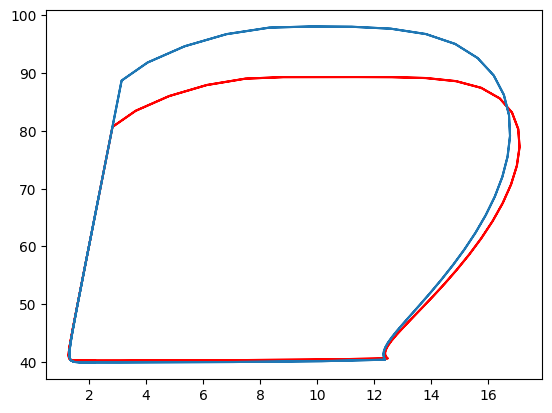

In [54]:
plt.plot(p_rv_surgery[0][4120:4300], v_rv_surgery[0][4120:4300], 'r' )
plt.plot(p_rv_surgery[1][4120:4300], v_rv_surgery[1][4120:4300])
plt.show()